# Capter 5: Discussion

This chapter analyses and interprets the results presented in the previous chapter, providing a deeper context and meaning. The last part explores current limitations and potential further research to guide future developments.


## Mixed Loss Function

To allow a meaningful comparison between these two losses, the Mean Squared Error was scaled by a factor of 100, as it was consistently two orders of magnitude lower than the Dice Score upon convergence.


In [10]:
import pickle
from matplotlib import pyplot as plt
import numpy as np

In [11]:
path = "outputs/_metricsDynamic/mse_dice.pkl"

with open(path, "rb") as f:
    data = pickle.load(f)

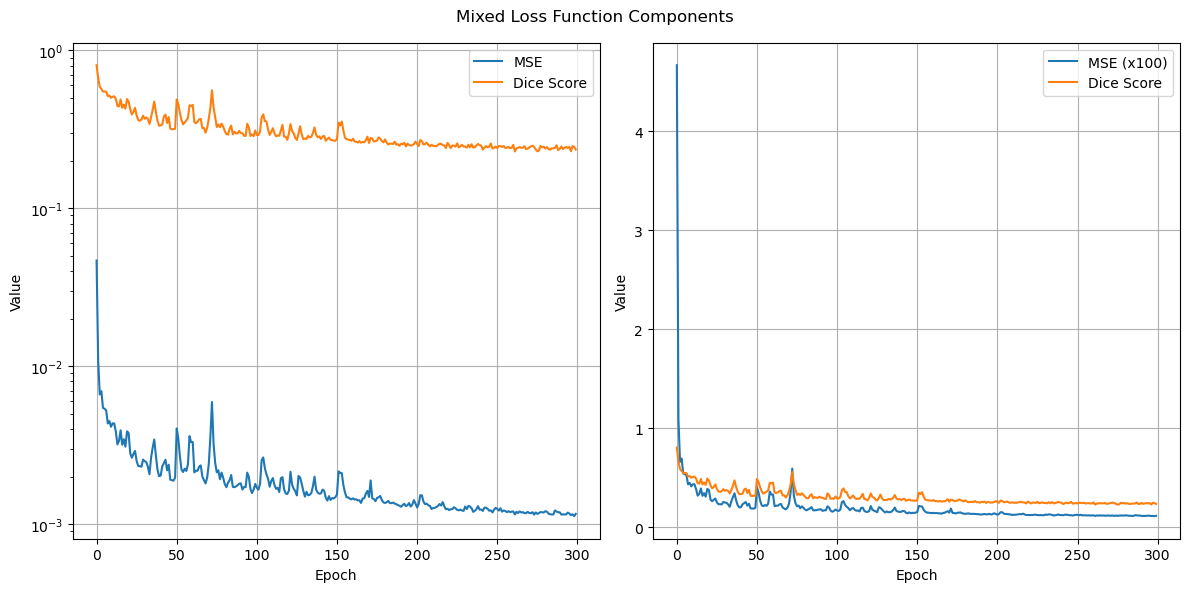

In [12]:
fig = plt.figure(figsize=(12, 6))

# First subplot
ax1 = fig.add_subplot(121)
ax1.plot(data["mse"], label="MSE")
ax1.plot(data["dice"], label="Dice Score")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Value")
ax1.set_yscale("log")
ax1.grid()
ax1.legend()

# Second subplot with MSE scaled to 100
ax2 = fig.add_subplot(122)
ax2.plot(np.array(data["mse"]) * 100, label="MSE (x100)")
ax2.plot(data["dice"], label="Dice Score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Value")
ax2.grid()
ax2.legend()

# Set fig title
fig.suptitle("Mixed Loss Function Components")
plt.tight_layout()

plt.show()